In [1]:
# deepfool 算法
import torch
import torchvision
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients

from torchvision import models
import numpy as np
import cv2

# test
b = Variable(torch.FloatTensor([2]), requires_grad=True)
a = b * b
print(a)
print(b)
a.backward()
print(b.grad.data)

tensor([4.], grad_fn=<MulBackward0>)
tensor([2.], requires_grad=True)
tensor([4.])


In [2]:
# 对比展现原始图片和对抗样本图片
def show_images_diff(original_img, original_label, adversarial_img, adversarial_label):
    import matplotlib.pyplot as plt

    plt.figure()

    original_img = original_img / 255.0
    adversarial_img = adversarial_img / 255.0

    plt.subplot(131)
    plt.title("Original")
    plt.imshow(original_img)
    plt.axis("off")

    plt.subplot(132)
    plt.title("Adversarial")
    plt.imshow(adversarial_img)
    plt.axis("off")

    plt.subplot(133)
    plt.title("Adversarial-Original")
    difference = adversarial_img - original_img
    # (-1,1)  -> (0,1)
    difference = difference / abs(difference).max() / 2.0 + 0.5
    plt.imshow(difference, cmap=plt.cm.gray)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
# 获取计算设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 图像加载和处理
image_path = "./images/tt100k_394.jpg"
img = cv2.imread(image_path)  # type: ignore
# img = cv2.resize(src=img, dsize=(224, 224))
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img).to(device=device).unsqueeze(0).float()

In [4]:
from ultralytics import YOLO
import numpy as np

yolo = YOLO(model="../models/yolov8-tt100k.pt")
yolo = yolo.cuda()

results = yolo(img)
# print(results[0].boxes)
for result in results:
    boxes = result.boxes
    masks = result.masks
    keypoints = result.keypoints
    probs = result.probs
    obb = result.obb
    # result.show()

model = yolo.model
if len(results) > 0 and len(results[0].boxes) > 0:
    # 获取最高置信度的检测框的类别
    best_conf_index = results[0].boxes.conf.argmax()
    orig_label = int(results[0].boxes.cls[best_conf_index].cpu().numpy())
    print(f"label={orig_label}")
else:
    print("No objects detected")


WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 255.0. Dividing input by 255.
0: 224x224 (no detections), 220.9ms
Speed: 0.0ms preprocess, 220.9ms inference, 28.4ms postprocess per image at shape (1, 3, 224, 224)
No objects detected


In [5]:
# 对抗攻击参数
epochs = 100
overshot = 0.02
num_classes = 1000  # 根据实际类别数调整
# 禁用模型参数梯度（仅优化输入图像）
for param in yolo.model.parameters():
    param.requires_grad = False
# 对抗攻击迭代
for epoch in range(epochs):
    # 前向传播并启用梯度（关键！）
    with torch.enable_grad():
        output = yolo.model(img)  # 直接调用模型的前向传播（非 predict 接口）
        # 注意：YOLOv8 的输出格式可能为 (boxes, cls_scores)，需根据模型结构调整
        # 假设 output 是分类分数（需确认模型输出结构）
        # 例如，若模型输出是 ( detections, cls_logits )，则取 cls_logits
        scores = output[1] if isinstance(output, tuple) else output  # 根据实际输出调整

    # 检查当前预测标签
    current_label = scores.argmax().item()
    current_score = scores[0, current_label].item()
    print(f"Epoch {epoch}: Current label {current_label}, Score {current_score:.4f}")

    # 攻击成功条件
    if current_label != orig_label:
        print(f"Attack successful at epoch {epoch}!")
        break

    # 计算梯度（针对原始标签）
    yolo.model.zero_grad()  # 清零模型梯度（仅图像需要梯度）
    scores[0, orig_label].backward(retain_graph=True)  # 反向传播原始标签的梯度
    grad_orig = img.grad.data.clone()  # 保存原始标签的梯度

    # 寻找最易攻击的类别（其他类别）
    min_perturbation = float("inf")
    best_w = None
    for k in range(num_classes):
        if k == orig_label:
            continue

        # 计算当前类别 k 的梯度
        yolo.model.zero_grad()
        scores[0, k].backward(retain_graph=True)
        grad_k = img.grad.data.clone()

        # 计算扰动方向 w_k 和对应的扰动大小
        w_k = grad_k - grad_orig
        f_k = (scores[0, k] - scores[0, orig_label]).item()
        pert_k = abs(f_k) / (torch.norm(w_k) + 1e-8)  # 避免除零

        if pert_k < min_perturbation:
            min_perturbation = pert_k
            best_w = w_k

    # 更新图像（添加扰动）
    if best_w is not None:
        r_i = (min_perturbation + 1e-8) * best_w / (torch.norm(best_w) + 1e-8)
        img.data += (1 + overshot) * r_i  # 累积扰动
        img.data.clamp_(0, 1)  # 限制像素范围（根据预处理调整，如 [0,1] 或 [0,255]）

    # 清零图像梯度（为下一轮迭代准备）
    img.grad.data.zero_()

AttributeError: 'list' object has no attribute 'argmax'

In [ ]:
w = np.zeros(input_shape)
r_rot = np.zeros(input_shape)  # 更新矩阵
for epoch in range(epochs):
    scores = model(img).data.cpu().numpy()[0]
    label = np.argmax(scores)
    print("epoch={} label={} score={}".format(epoch, label, scores[label]))
    # 如果无定向攻击成功
    if label != orig_label:
        break
    pert = np.inf  # 用来记录最小距离
    output[0, orig_label].backward(retain_graph=True)  # 只管当前类别的情况
    grad_orig = img.grad.data.cpu().numpy().copy()  # 前一次梯度
    for k in range(1, num_classes):
        if k == orig_label:
            continue

        # 梯度清零
        zero_gradients(img)

        output[0, k].backward(retain_graph=True)
        cur_grad = img.grad.data.cpu().numpy().copy()
        # 计算w_k和f_k
        w_k = cur_grad - grad_orig
        f_k = (output[0, k] - output[0, orig_label]).data.cpu().numpy()
        pert_k = abs(f_k) / np.linalg.norm(w_k.flatten())  # 距离
        # 选择pert最小值，提速作用，快速收敛到最易攻破的类别
        if pert_k < pert:
            pert = pert_k
            w = w_k

    # 计算r_i和r_tot
    r_i = (pert + 1e-8) * w / np.linalg.norm(w)
    r_tot = np.float32(r_rot + r_i)
    img.data = img.data + (1 + overshot) * torch.from_numpy(r_tot).to(device)

(3, 224, 224)


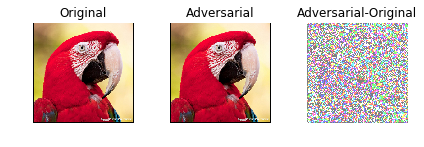

In [ ]:
adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv=adv.transpose(1,2,0)
adv = (adv * std) + mean
adv = adv * 255.0
adv=np.clip(adv,0,255).astype(np.uint8)
show_images_diff(orig,orig_label,adv,label)